In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics


In [2]:
#import the dataset from GitHub
url = 'https://raw.githubusercontent.com/jamesdinardo/Retail-Forecasting/master/final_df.csv'
df = pd.read_csv(url)

In [3]:
print('Shape of final dataframe: {}'.format(df.shape))
df.head()

Shape of final dataframe: (418660, 16)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Type,Size,Weekly_Sales
0,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1,A,151315,24924.50
1,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,A,151315,50605.27
2,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,3,A,151315,13740.12
3,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,4,A,151315,39954.04
4,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5,A,151315,32229.38


In [4]:
#convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

#convert Store, Dept, and Type columns to category
df['Store'] = df['Store'].astype('category')

df['Dept'] = df['Dept'].astype('category')

df['Type'] = df['Type'].astype('category')

In [5]:
#create separate features for Week, Month, and Year
df['Month'] = df['Date'].dt.month
df['Month'] = df['Month'].astype('category')

df['Week'] = df['Date'].dt.week
df['Week'] = df['Week'].astype('category')

df['Year'] = df['Date'].dt.year
df['Year'] = df['Year'].astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418660 entries, 0 to 418659
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         418660 non-null  category      
 1   Date          418660 non-null  datetime64[ns]
 2   Temperature   418660 non-null  float64       
 3   Fuel_Price    418660 non-null  float64       
 4   MarkDown1     418660 non-null  float64       
 5   MarkDown2     418660 non-null  float64       
 6   MarkDown3     418660 non-null  float64       
 7   MarkDown4     418660 non-null  float64       
 8   MarkDown5     418660 non-null  float64       
 9   CPI           418660 non-null  float64       
 10  Unemployment  418660 non-null  float64       
 11  IsHoliday     418660 non-null  bool          
 12  Dept          418660 non-null  category      
 13  Type          418660 non-null  category      
 14  Size          418660 non-null  int64         
 15  Weekly_Sales  418

In [7]:
df.drop('Date', axis=1, inplace=True)

In [8]:
#create dummy variables
df_dummies = pd.get_dummies(df)

In [9]:
X_train = df_dummies.loc[(df['Year']==2010) | (df['Year']==2011), :].drop('Weekly_Sales', axis=1).values
X_test = df_dummies.loc[df['Year']==2012, :].drop('Weekly_Sales', axis=1).values
y_train = df_dummies.loc[(df['Year']==2010) | (df['Year']==2011), 'Weekly_Sales'].values.reshape(-1, 1)
y_test = df_dummies.loc[df['Year']==2012, 'Weekly_Sales'].values.reshape(-1, 1)

print(X_train.shape)
print(X_test.shape)

(293146, 207)
(125514, 207)


In [10]:
dt = DecisionTreeRegressor(max_depth=10, random_state=0)

In [11]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [12]:
y_pred = dt.predict(X_test)

print('R2 with max depth of 10: {:.2f}'.format(metrics.r2_score(y_test, y_pred)))
print('RMSE with max depth of 10: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

R2 with max depth of 10: 0.70
RMSE with max depth of 10: 12145.74


In [13]:
#Create a decision tree with max depth of 4 for plotting
dt_pruned = DecisionTreeRegressor(random_state=0, max_depth=4)
dt_pruned.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=4, random_state=0)

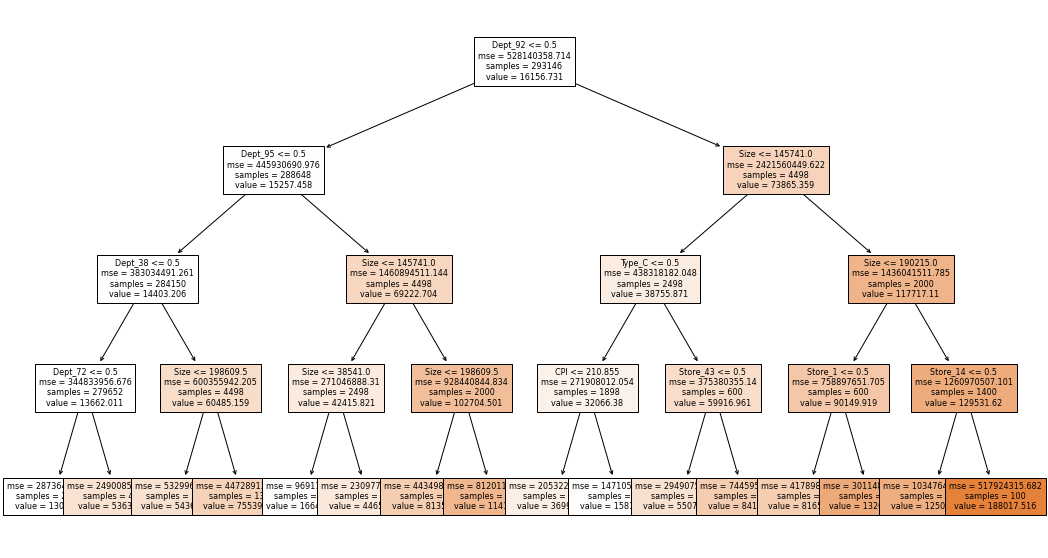

In [14]:
#plot the tree
features = list(df_dummies.drop('Weekly_Sales', axis=1).columns)

fig, ax = plt.subplots(figsize=(18,10))
tree.plot_tree(dt_pruned, feature_names=features, fontsize=8, filled=True)
plt.show()

From this it looks like the department and size are the biggest predictors of sales. We can also take a look at the feature importances:

In [15]:
#calculate feature importances
pd.DataFrame({'Feature': features, 'Feature Importance':dt.feature_importances_}).sort_values(by='Feature Importance', ascending=False).head(15)


,Feature,Feature Importance
10,Size,0.225039
129,Dept_92,0.142726
132,Dept_95,0.124840
92,Dept_38,0.091053
116,Dept_72,0.063943
127,Dept_90,0.060235
94,Dept_40,0.049398
57,Dept_2,0.047278
128,Dept_91,0.029773
198,Week_47,0.029687


Next, let's try out a few different hyperparameter values for max_depth, max_leaf_nodes, and min_sample_split

In [16]:
#iterate over different values for max_depth
md_values = np.array([4, 10, 15, 20, 30, 40, None])

for i in md_values:
    dt = DecisionTreeRegressor(random_state=0, max_depth=i)
    dt.fit(X_train, y_train)
    print('Max Depth of {}: {:.2f}'.format(i, dt.score(X_test, y_test)))

Max Depth of 4: 0.42
Max Depth of 10: 0.70
Max Depth of 15: 0.79
Max Depth of 20: 0.81
Max Depth of 30: 0.85
Max Depth of 40: 0.87
Max Depth of None: 0.87


In [17]:
#iterate over different possible max leaf node values and see which performs best
ml_values = np.array([5, 10, 15, 20, 25, 30, 35, None])
for i in ml_values:
    dt = DecisionTreeRegressor(random_state=0, max_depth=10, max_leaf_nodes=i)
    dt.fit(X_train, y_train)
    print('Max leaf nodes = {}: {:.2f}'.format(i, dt.score(X_test, y_test)))
                    

Max leaf nodes = 5: 0.35
Max leaf nodes = 10: 0.50
Max leaf nodes = 15: 0.59
Max leaf nodes = 20: 0.62
Max leaf nodes = 25: 0.64
Max leaf nodes = 30: 0.65
Max leaf nodes = 35: 0.66
Max leaf nodes = None: 0.70


In [18]:
#iterate over different possible min_sample_split and see which performs best
ms_values = np.array([0.001, 0.01, 0.1, .2, .3, .4])
for i in ms_values:
    dt = DecisionTreeRegressor(random_state=0, max_depth=10, min_samples_split=i)
    dt.fit(X_train, y_train)
    print('Min sample split = {}: {:.2f}'.format(i, dt.score(X_test, y_test)))
                    

Min sample split = 0.001: 0.70
Min sample split = 0.01: 0.65
Min sample split = 0.1: 0.54
Min sample split = 0.2: 0.54
Min sample split = 0.3: 0.54
Min sample split = 0.4: 0.39


The default values for max_depth, max_leaf_nodes, and min_sample_split result in the highest scores, but are likely overfitting. In other words, if we allow the tree to grow as much as it wants, it will perform very well on the validation set but may not generalize well to new data.

Finally, we can try to reduce the dimensionality of the dataset, to see if we can still get good performance with fewer features. Let's use only the top 25% features by feature importance

In [19]:
dt = DecisionTreeRegressor(max_depth=10, random_state=0)

In [20]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [21]:
y_pred = dt.predict(X_test)

print('R2 with max depth of 10, all features: {:.2f}'.format(dt.score(X_test, y_test)))
print('RMSE with max depth of 10, all features: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

R2 with max depth of 10, all features: 0.70
RMSE with max depth of 10, all features: 12145.74


In [22]:
#calculate feature importances
print('Total features: {}'.format(len(dt.feature_importances_)))
feature_importances = pd.DataFrame({'Feature': features, 'Feature Importance':dt.feature_importances_}).sort_values(by='Feature Importance', ascending=False)
display(feature_importances.iloc[:50, :])

Total features: 207


,Feature,Feature Importance
10,Size,0.225039
129,Dept_92,0.142726
132,Dept_95,0.124840
92,Dept_38,0.091053
116,Dept_72,0.063943
127,Dept_90,0.060235
94,Dept_40,0.049398
57,Dept_2,0.047278
128,Dept_91,0.029773
198,Week_47,0.029687


In [23]:
#drop all features except the top 50 and years
features_to_drop = feature_importances.iloc[50:, 0]
features_to_drop = features_to_drop[~features_to_drop.str.contains('Year')]

In [24]:
df_dummies_top_features = df_dummies.drop(features_to_drop, axis=1)
df_dummies_top_features.shape

(418660, 54)

In [25]:
#split into train test based on year
X_train = df_dummies_top_features.loc[(df['Year']==2010) | (df['Year']==2011), :].drop('Weekly_Sales', axis=1).values
X_test = df_dummies_top_features.loc[df['Year']==2012, :].drop('Weekly_Sales', axis=1).values
y_train = df_dummies_top_features.loc[(df['Year']==2010) | (df['Year']==2011), 'Weekly_Sales'].values.reshape(-1, 1)
y_test = df_dummies_top_features.loc[df['Year']==2012, 'Weekly_Sales'].values.reshape(-1, 1)

print(X_train.shape)
print(X_test.shape)

(293146, 53)
(125514, 53)


In [26]:
dt = DecisionTreeRegressor(max_depth=10, random_state=0)

In [27]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [28]:
y_pred = dt.predict(X_test)

print('R2 with max depth of 10, 53 features: {:.2f}'.format(dt.score(X_test, y_test)))
print('RMSE with max depth of 10, 53 features: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

R2 with max depth of 10, 53 features: 0.70
RMSE with max depth of 10, 53 features: 12156.50


Our model performs roughly the same with only a quarter of the features, so this is an improvement.